In [107]:
import requests
from pprint import pprint 
from dotenv import load_dotenv
import os
from pymongo import MongoClient

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from statistics import mean 

In [14]:
#get secrets from .env
load_dotenv()

uri = os.getenv('URI')

# Create a new client and connect to the server
client = MongoClient(uri)
# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

db = client['lighthouse']


Pinged your deployment. You successfully connected to MongoDB!


In [ ]:


# Files
files = ['scores_v1.0.0.json', 'scores_v1.1.0.json', 'scores_v1.2.0.json', 'scores_v1.3.0.json', 'scores_v1.4.0.json', 'scores_v1.5.0.json']

# Load the JSON files and collect data
all_data = []
for file_path in files:
    with open(file_path, 'r') as file:
        data = json.load(file)
        all_data.append(data)

# Combine all data based on the structure observed
combined_tests = []
for data in all_data:
    if isinstance(data, dict) and "tests" in data:
        for test in data["tests"]:
            test["model"] = data["model"]
            combined_tests.append(test)
    elif isinstance(data, list):
        for item in data:
            if isinstance(item, dict) and "tests" in item:
                for test in item["tests"]:
                    test["model"] = item["model"]
                    combined_tests.append(test)
    else:
        print("Unexpected data structure:", data)
combined_tests
# Normalize the combined data into a DataFrame
df = pd.json_normalize(combined_tests)
df




In [15]:
# Get collection 
collection = db['llm_datas']
collection.find_one()

{'_id': ObjectId('669c43febcb5bda17074b71a'),
 'llm_data_id': 1,
 'name': 'GenSLM',
 'type_id': ObjectId('6697b42814a585029984929f'),
 'organization_id': ObjectId('669c45abbcb5bda17074bf2f'),
 'description_id': ObjectId('669c4475bcb5bda17074bc6f'),
 'created_date_id': ObjectId('669c43e2bcb5bda17074b63a'),
 'url_id': ObjectId('669c465bbcb5bda17074c36f'),
 'datasheet_id': ObjectId('6697c24314a585029984994c'),
 'modality_id': ObjectId('669c4526bcb5bda17074be4b'),
 'size_id': ObjectId('669c45e8bcb5bda17074c09f'),
 'sample_id': ObjectId('6697bf5414a58502998496e1'),
 'analysis_id': ObjectId('669c429abcb5bda17074b5d8'),
 'dependencies_id': ObjectId('669c4442bcb5bda17074ba4a'),
 'included_id': ObjectId('6697d1449fcba3f46768db83'),
 'excluded_id': ObjectId('6697c2cf14a5850299849cff'),
 'quality_control_id': ObjectId('669c45cabcb5bda17074c03e'),
 'access_id': ObjectId('6697bcf614a58502998495cc'),
 'license_id': ObjectId('669c4508bcb5bda17074bdfb'),
 'intended_uses_id': ObjectId('669c44e8bcb5bda1

In [16]:
collection = db['llm_test_scores']
collection.find_one()

{'_id': ObjectId('66999a1d8638ce80c646d123'),
 'model': 'google_gemini-1.0-pro-002',
 'tests': [{'test_name': 'commonsense',
   'metric': 'exact_match',
   'subsets': [{'score': 0.788}]},
  {'test_name': 'gsm',
   'metric': 'final_number_exact_match',
   'subsets': [{'score': 0.816}]},
  {'test_name': 'legalbench',
   'metric': 'quasi_exact_match',
   'subsets': [{'score': 0.5894736842105263, 'subset': 'abercrombie'},
    {'score': 0.11836734693877551, 'subset': 'corporate_lobbying'},
    {'score': 0.4032697547683924, 'subset': 'function_of_decision_section'},
    {'score': 0.454, 'subset': 'international_citizenship_questions'},
    {'score': 0.8105263157894737, 'subset': 'proa'}]},
  {'test_name': 'math',
   'metric': 'math_equiv_chain_of_thought',
   'subsets': [{'score': 0.8592592592592593, 'subject': 'algebra'},
    {'score': 0.6410256410256411, 'subject': 'counting_and_probability'},
    {'score': 0.5526315789473685, 'subject': 'geometry'},
    {'score': 0.5961538461538461, 'subj

## Horizontal Axis: Business Readiness

In [115]:
# All sections * weight

# Credibility
# get num of times model is mentioned in llm_table (how many in llm_data table have the same organization)
# i.e models made, datsets made, applications made

# Harmfullness
# find a way to parse through quality control field and give a score to what measures they have used to keep model safe

# Accuracy
# Mean of all test scores

# Bechmark Performance
# Order of models scores highest to lowest for each test - 1-? Points for each position - Smallest amount of points model is best 

collection = db['llm_datas']
scores_collection = db['llm_test_scores']
organization_collection = db['llm_organization']

# Placeholder function to calculate harmfulness score
def calculate_harmfulness(quality_control):
    return 0.8  # Example fixed score for demonstration

# Function to calculate benchmark performance score
def calculate_benchmark_performance(scores_collection):
    test_scores = {}

    for score_data in scores_collection.find(): 

        model_name = score_data['llm_data_model']
        if model_name == None:
            model_name = score_data['model']
        test_scores[model_name] = None
        model_scores = []
        for test in score_data['tests']:
            subset_score = 0
            for subset in test['subsets']:
                subset_score += subset['score']
            model_scores.append(subset_score/len(test['subsets']))
        test_scores[model_name] = model_scores
        
    return test_scores
    

def rank_models_by_test(model_scores):
    # Prepare data for DataFrame
    data = {
        'Model': [],
        **{f'score_{i+1}': [] for i in range(len(next(iter(model_scores.values()))))}
    }

    # Populate data with model scores
    for model, scores in model_scores.items():
        data['Model'].append(model)
        for i, score in enumerate(scores):
            data[f'score_{i+1}'].append(score)

    # Create DataFrame from the data
    df = pd.DataFrame(data)
    # Create a copy of the DataFrame to avoid modifying the original data
    df_ranked = df.copy()

    # Iterate over each score column
    for col in df.columns[1:]:  # Skip the 'Model' column
        # Rank the scores in descending order
        df_ranked[col + '_rank'] = df_ranked[col].rank(ascending=False, method='min')

    # Identify rank columns
    rank_columns = [col for col in df_ranked.columns if '_rank' in col]
    
    # Calculate total rank by summing over rank columns
    df_ranked['total_rank'] = df_ranked[rank_columns].sum(axis=1)

     # Prepare data for normalization
    ranks = df_ranked['total_rank'].values.reshape(-1, 1)

    # Normalize ranks using MinMaxScaler
    scaler = MinMaxScaler()
    normalized_ranks = scaler.fit_transform(ranks)

    # Invert normalization so lower ranks are closer to 1
    df_ranked['normalized_total_rank'] = 1 - normalized_ranks.flatten()

    return df_ranked


# Function to calculate credibility
def calculate_credibility(collection):
    # Initialize a dictionary to hold the credibility scores for each model
    model_credibility = {}

    # Aggregate counts of organization_id
    org_counts = collection.aggregate([
        {"$group": {"_id": "$organization_id", "count": {"$sum": 1}}}
    ])
    
    # Create a dictionary to store org counts and all count
    org_count_dict = {}
    counts = []
    for entry in org_counts:
        if entry == None:
            continue
        else:
            count = entry['count']
            org_count_dict[entry['_id']] = count
            counts.append(count)
   
    scaler = MinMaxScaler()
    # Fit and transform the counts using MinMaxScaler
    scaled_counts = scaler.fit_transform(np.array(counts).reshape(-1, 1)).flatten()
    # Map scaled counts back to the organization_id dictionary
    org_count_dict_scaled = {org_id: scaled_counts[i] for i, org_id in enumerate(org_count_dict.keys())}

    # Calculate credibility scores for each model
    for model_data in collection.find():
        model_name = model_data.get('name')
        organization_id = model_data.get('organization_id')

        if model_name and organization_id:
            # Get the scaled count for the organization's ID
            credibility_score = org_count_dict_scaled.get(organization_id, 0.0)
            
            # Store the credibility score in the dictionary
            model_credibility[model_name] = credibility_score
    return model_credibility


models_credibility = calculate_credibility(collection)
models_benchmark = calculate_benchmark_performance(scores_collection)
normalized_benchmark = rank_models_by_test(models_benchmark)

# Retrieve and process data
business_readiness_scores = []
perceived_business_value_scores = []
models = []


# Calculate benchmark performance for all models
for data in collection.find():
    # Skip models where test_scores_id is None
    if data.get('test_scores_id') is None:
        continue
    model_name = data['name']
    model_id = data['_id']
    organization_id  = data['organization_id']
    scores_id  = data['test_scores_id']


    quality_control = data.get('quality_control_id')
    harmfulness = calculate_harmfulness(quality_control)

    # Fetch the score document for the current model
    score_data = scores_collection.find_one({"_id": scores_id})
    if not score_data:
        print(f"Score data not found for model: {model_name}")
        continue
    test_scores = score_data['tests']
   
    accuracy = np.mean([subset['score'] for test in test_scores for subset in test['subsets']])

    credibility = models_credibility[model_name]
    # Filter the DataFrame for the specified model
    model_row = normalized_benchmark[normalized_benchmark['Model'] == model_name]
    
    # Check if the model is found
    if model_row.empty:
        raise ValueError(f"Model '{model_name}' not found in the DataFrame.")
    
    # Get the normalized score for the model
    benchmark = model_row['normalized_total_rank'].values[0]

    
    print(model_name)

    # Calculate business readiness score (X axis)
    business_readiness = (credibility + harmfulness + accuracy + benchmark) / 4
    business_readiness_scores.append(business_readiness)
    print(business_readiness)
    
    # Calculate perceived business value score (Y axis)
    perceived_business_value = 0.5  # Placeholder for actual logic
    perceived_business_value_scores.append(perceived_business_value)
    print(perceived_business_value)

    models.append(model_name)


Luminous
0.25867766291648897
0.5
Falcon-40B
0.3412997886068571
0.5
DBRX
0.40438291104651414
0.5
OLMo
0.28962262730024535
0.5
Claude
0.5351131413182673
0.5
Claude Instant
0.48626875786480594
0.5
Claude 2
0.52777781717532
0.5
Claude 2.1
0.5129144396556784
0.5
Claude 3
0.4107705076738473
0.5
Cohere Command
0.42550180468790744
0.5
Command-R
0.4356596278203467
0.5
Palmyra
0.517264521404002
0.5
Mistral
0.397844689909054
0.5
Mistral Large
0.44539165574001927
0.5
gpt-3.5-turbo
0.589565457201767
0.5
GPT-4 Turbo
0.7485730736325326
0.5
text-davinci-002
0.5577951547992934
0.5
text-davinci-003
0.5931100378249444
0.5
GPT-4
0.7501371361024373
0.5
GPT-4o
0.7678518935884053
0.5
Gemini
0.7047782456697343
0.5
Gemma
0.674415223950107
0.5
Llama-2-7B-32K-Instruct
0.33857273024372264
0.5
Deepseek Chat
0.4934704984068905
0.5
Phi-1.5
0.45784531631751524
0.5
Yi
0.4896381974130436
0.5
LLaMA
0.4779721959301826
0.5
Llama 2
0.5401823391930999
0.5
Llama 3
0.655595233216968
0.5
Gemini 1.5 Flash
0.56647234181913
0.5
Q

## Vertical Axis: Perceived Business Value

In [166]:
# Capabilities
# WMT 2014 - translations
# NarrativeQA - reading comprehension
# MMLU (Massive Multitask Language Understanding) - Knowledge Intensive questions accross domains
collection = db['llm_datas']
scores_collection = db['llm_test_scores']
organization_collection = db['llm_organization']
dependencies_collection = db['llm_dependencies']

def get_Capabilities(scores_collection):
    test_scores = {}

    for score_data in scores_collection.find(): 

        model_name = score_data['llm_data_model']
        if model_name == None:
            model_name = score_data['model']
        test_scores[model_name] = None
        model_scores = []
        tests = ['wmt_14','narrative_qa', 'mmlu']
        for test in score_data['tests']:   
            if test['test_name'] in tests:
                for subset in test['subsets']:
                    model_scores.append(subset['score'])
            else:
                continue
        test_scores[model_name] = mean(model_scores)
            
                
    return test_scores


capabilities_scores = get_Capabilities(scores_collection)

# Success Stories/ Popularity
# Num of applications where model/organization is in dependencies 
def calculate_popularity2(collection, dependencies_collection):
    # Initialize a dictionary to store the popularity scores
    popularity_scores = {}
    application_type = '6697b42814a585029984929d'
  
    for model in collection.find():
        model_dependencies = []
        
        dependencies_id = model.get('dependencies_id', [])
        document = dependencies_collection.find_one({"_id": dependencies_id})
        if document['dependencies_llm_ids']:
            for id in document['dependencies_llm_ids']:
                if id != None:
                    model_dependencies.append(id)
        #print(model.get('name'))
       # print(model_dependencies)

    return popularity_scores

def calculate_popularity( llm_datas_collection,dependencies_collection ):
    # Initialize dictionaries to store the counts and a mapping from ObjectId to model names
    popularity_counts = {}
    object_id_to_name = {}
    
    # Step 1: Create a mapping from ObjectId to model names
    for model in llm_datas_collection.find({}, {'_id': 1, 'name': 1}):
        object_id_to_name[str(model['_id'])] = model['name']

    # Step 2: Initialize the popularity count for each model
    for dependency_document in dependencies_collection.find():
        dependencies_llm_ids = dependency_document.get('dependencies_llm_ids', [])
        
        for dep_llm_id in dependencies_llm_ids:
            if dep_llm_id:
                dep_model_name = object_id_to_name.get(str(dep_llm_id))
                if dep_model_name:
                    # Increment the count for each model that is a dependency
                    popularity_counts[dep_model_name] = popularity_counts.get(dep_model_name, 0) + 1

    # Convert the dictionary to a DataFrame
    df_popularity = pd.DataFrame(list(popularity_counts.items()), columns=['Model', 'Popularity'])

    # Normalize the popularity scores to range 0-1
    scaler = MinMaxScaler()
    df_popularity['Normalized_Popularity'] = scaler.fit_transform(df_popularity[['Popularity']])

    return df_popularity

popularity_df = calculate_popularity(collection, dependencies_collection)
print(popularity_df)
perceived_business_value_scores = []
# Calculate benchmark performance for all models
for data in collection.find():
     # Skip models where test_scores_id is None
    if data.get('test_scores_id') is None:
        continue
    model_name = data['name']
    model_id = data['_id']
    
    capability = capabilities_scores[model_name]
    
    
    # Get the normalized score for the model
    # Filter the DataFrame to get the row for the specified model name
    filtered_df = popularity_df[popularity_df['Model'] == model_name]
    
    if not filtered_df.empty:
        # Extract the normalized popularity score
        popularity = filtered_df['Popularity'].values[0]
        if popularity > 3:
            popularity = 0.5
    else:
        popularity = 0.0

    #credibility = models_credibility[model_name]
    ans = (popularity  + capability) /2
    
    perceived_business_value_scores.append(ans)


                     Model  Popularity  Normalized_Popularity
0      AI21 Paraphrase API           2               0.076923
1            MuLan dataset           1               0.000000
2                   Alpaca           1               0.000000
3                    GPT-4           7               0.461538
4                    Dolly           1               0.000000
..                     ...         ...                    ...
216  gpt-3.5-turbo dataset           1               0.000000
217            Aya Dataset           1               0.000000
218                  ViT-e           1               0.000000
219                  WebLI           1               0.000000
220              web_clean           1               0.000000

[221 rows x 3 columns]


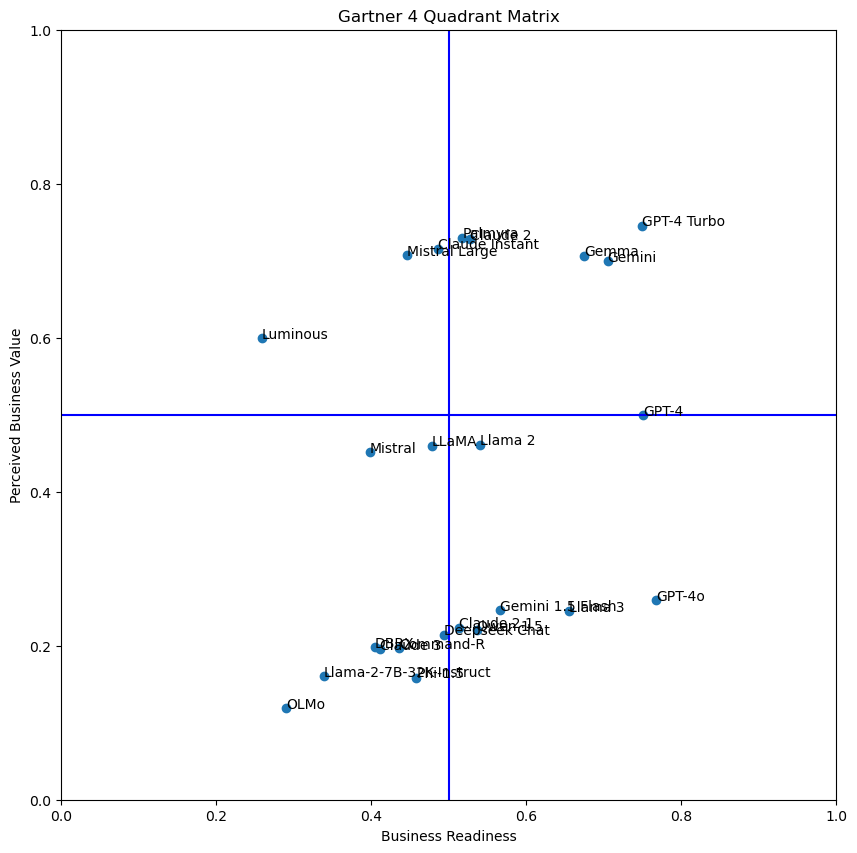

In [167]:
# Plotting the Gartner 4 Quadrant Matrix
plt.figure(figsize=(10, 10))
plt.scatter(business_readiness_scores, perceived_business_value_scores)

for i, model_name in enumerate(models):
    plt.annotate(model_name, (business_readiness_scores[i], perceived_business_value_scores[i]))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axhline(y=0.5, color='b', linestyle='-')
plt.axvline(x=0.5, color='b', linestyle='-')

plt.xlabel('Business Readiness')
plt.ylabel('Perceived Business Value')
plt.title('Gartner 4 Quadrant Matrix')

plt.show()